# Survival Analysis with scikit-survival

This notebook is based closely on the scikit-survival [user guide](https://scikit-survival.readthedocs.io/en/stable/user_guide/index.html) and [introductory tutorial](https://scikit-survival.readthedocs.io/en/stable/user_guide/00-introduction.html).

## Survival Data

![image](assets/censoring.png)

Survival analysis is time-to-event analysis with (typically) a single event of interest—death. It is a flavor of regression (we want to predict the probability of survival as a function of time, which is continuous). The data is also trivially time-dependent due to the presense of *censoring* in the dataset: some patients may be withdrawn from the study, lost to follow-up, or not experience an event (death) during the period of study at all. If the $i$-th patient is *uncensored*, then the event is actually observed, and the survival time (e.g., in months) recorded in the life table data denotes actual survival time $T_i$. If a patient is (right) *censored*, then this instead denotes the *censoring time* $U_i$, and in this case all we know about this patient's actual survival time is that $T_i > U_i$. Since censoring and death are mutually exclusive, one typically encodes this using an *event indicator* defined as follows:
$$
\delta_i = \begin{cases}
0, & T_i = U_i, \quad \text{(dead)} \\
1, & T_i > U_i, \quad \text{(censored)}
\end{cases}
$$
such that the *observed survival time* for the $i$-th patient in right-censored survival data is
$$
O_i = \delta_i T_i + (1 - \delta_i) U_i.
$$

## Cox proportional hazards model

This complication prevents us from performing ordinary multivariable regression with, say, MLE. One way out is the [proportional hazards assumption](https://en.wikipedia.org/wiki/Proportional_hazards_model#Introduction), which asserts that all covariates $X_i$ in the problem are related to the underlying baseline hazard function $\lambda_0(t)$ multiplicitavely. This gives us the Cox proportional hazards model, in which the hazard function is assumed to take the form
$$
\lambda(t|X_i) = \lambda_0(t) \exp(X_i \cdot \beta),
$$
which looks much like an ordinary multivariable exponential regression model, except for the introduction of the time-dependent nuisance parameter $\lambda_0(t)$. Using, e.g., Breslow's estimate of the baseline hazard function, one can show that the problem of determining the coefficients $\beta$ amounts to the maximization of a *partial likelihood*
$$
\text{PL}(\beta) = \prod_{i} \left\lparen \frac{\exp(X_i \cdot \beta)}{\sum_{j: t_j \ge t_i} \exp(X_j \cdot \beta)} \right\rparen^{\delta_i},
$$
which is independent of the baseline hazard function $\lambda_0(t)$. The negative log partial likelihood that an event is observed at time $t_i$ for any patient is then given by
$$
\text{NLPL}(\beta) = -\sum_{i} \delta_i \left\lparen X_i \cdot \beta - \log \sum_{j: t_j \ge t_i} \exp(X_j \cdot \beta) \right\rparen,
$$
which can be minimized to obtain the MPLE estimates $\hat{\beta}$ for the optimal model parameters. Note that the form of $\text{nll}(\beta)$ may be complicated in the presence of tied event times. Breslow's method uses the above procedure even when tied times exist, whereas Efron's method (which is generally regarded as more accurate) uses a more complicated expression for $\text{nll}(\beta)$.

## Hazard Ratios (HRs)

$\vdots$

## Example analysis using data from the Veterans' Administration Lung Cancer Trial

In [2]:
from sksurv.datasets import load_veterans_lung_cancer
help(load_veterans_lung_cancer)

# Load the data and display the life table
data_x, data_y = load_veterans_lung_cancer()
data_y

Help on function load_veterans_lung_cancer in module sksurv.datasets.base:

load_veterans_lung_cancer()
    Load and return data from the Veterans' Administration
    Lung Cancer Trial
    
    The dataset has 137 samples and 6 features.
    The endpoint is death, which occurred for 128 patients (93.4%).
    
    See [1]_ for further description.
    
    Returns
    -------
    x : pandas.DataFrame
        The measurements for each patient.
    
    y : structured array with 2 fields
        *Status*: boolean indicating whether the endpoint has been reached
        or the event time is right censored.
    
        *Survival_in_days*: total length of follow-up
    
    References
    ----------
    .. [1] Kalbfleisch, J.D., Prentice, R.L.:
        "The Statistical Analysis of Failure Time Data." John Wiley & Sons, Inc. (2002)



array([( True,  72.), ( True, 411.), ( True, 228.), ( True, 126.),
       ( True, 118.), ( True,  10.), ( True,  82.), ( True, 110.),
       ( True, 314.), (False, 100.), ( True,  42.), ( True,   8.),
       ( True, 144.), (False,  25.), ( True,  11.), ( True,  30.),
       ( True, 384.), ( True,   4.), ( True,  54.), ( True,  13.),
       (False, 123.), (False,  97.), ( True, 153.), ( True,  59.),
       ( True, 117.), ( True,  16.), ( True, 151.), ( True,  22.),
       ( True,  56.), ( True,  21.), ( True,  18.), ( True, 139.),
       ( True,  20.), ( True,  31.), ( True,  52.), ( True, 287.),
       ( True,  18.), ( True,  51.), ( True, 122.), ( True,  27.),
       ( True,  54.), ( True,   7.), ( True,  63.), ( True, 392.),
       ( True,  10.), ( True,   8.), ( True,  92.), ( True,  35.),
       ( True, 117.), ( True, 132.), ( True,  12.), ( True, 162.),
       ( True,   3.), ( True,  95.), ( True, 177.), ( True, 162.),
       ( True, 216.), ( True, 553.), ( True, 278.), ( True,  1

In [3]:
import pandas as pd

pd.DataFrame.from_records(data_y[[11, 5, 32, 13, 23]], index=range(1, 6))

,Status,Survival_in_days
1,True,8.0
2,True,10.0
3,True,20.0
4,False,25.0
5,True,59.0


## [Kaplan-Meier estimator](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator) for the survival function

The Kaplan-Meier estimator for the survival function $S(t)$ (probability of surviving a duration longer than time $t$) is
$$
\hat{S}(t) = \prod_{i: t_i < t} \left\lparen 1 - \frac{d_i}{n_i} \right\rparen,
$$
where $t_i$ is a time where at least one event happened, $d_i$ is the total number of events that happened at time $t_i$, and $n_i$ is the number of individuals known to have survived (not yet died or been censored) up to time $t_i$.

Note that while $\hat{S}(t)$ is piecewise-constant, the true survival function $S(t)$ is continuous. We can produce the KM estimator for a given life table using scikit-survival in the following manner:

Text(0.5, 0, 'time $t$')

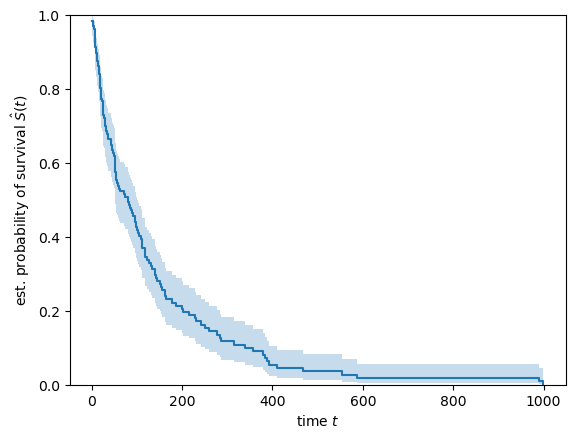

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob, conf_int = kaplan_meier_estimator(
    data_y["Status"], data_y["Survival_in_days"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

## Inference

The proportional hazards assumption provides a tractable means of assessing the importance of covariates/confounders in multivariable survival data. Let's look at a few inference tools standard to survival analysis.

### Log-rank tests and stratification

To compare survival functions in a rigorous way, we can use a *log-rank test*, which compares the total hazard rate with each group-specific hazard rate. The null (alternative) hypothesis for this test is that the groups have identical (different) hazard rates.

Let's look at how this works by exploring survival adjusted for a couple different covariates. First, consider treatment type:

In [5]:
data_x["Treatment"].value_counts()

Treatment
standard    69
test        68
Name: count, dtype: int64

We can try to eyeball the difference in survival functions, but this is not very conclusive, and quite subjective in general:

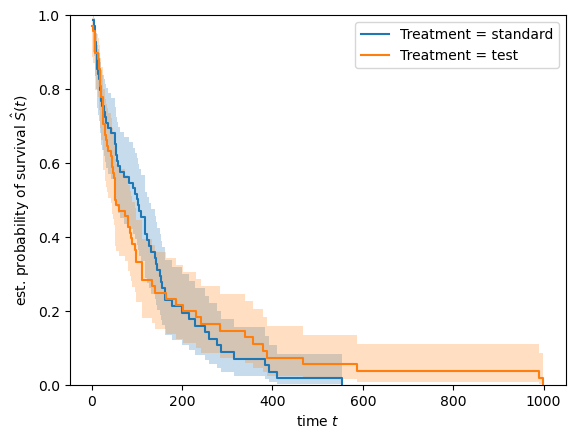

In [6]:
for treatment_type in ("standard", "test"):
    mask_treat = data_x["Treatment"] == treatment_type
    time_treatment, survival_prob_treatment, conf_int = kaplan_meier_estimator(
        data_y["Status"][mask_treat],
        data_y["Survival_in_days"][mask_treat],
        conf_type="log-log",
    )

    plt.step(time_treatment, survival_prob_treatment,
             where="post", label=f"Treatment = {treatment_type}")
    plt.fill_between(
        time_treatment, conf_int[0], conf_int[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

To quantify how different these survival functions are, we use a log-rank test:

In [7]:
from sksurv.compare import compare_survival
chi_squared, p_value, statistics, covariance_matrix = compare_survival(
    data_y,
    data_x["Treatment"] == "test",
    True,
)
print(f"chi-squared:\n{chi_squared}")
print(f"\np-value:\n{p_value}")
print(f"\nstatistics:\n{statistics}")
print(f"\ncovariance matrix:\n{covariance_matrix}")

chi-squared:
0.008227343202350305

p-value:
0.9277272333400758

statistics:
       counts  observed   expected  statistic
group                                        
False      69        64  64.500197  -0.500197
True       68        64  63.499803   0.500197

covariance matrix:
[[ 30.4103884 -30.4103884]
 [-30.4103884  30.4103884]]


Here, the log-rank test here confirms our intuition that stratifying by treatment type is not significant (p > 0.05).

Let's repeat this analysis for cancer cell type:

In [8]:
data_x["Celltype"].value_counts()

Celltype
smallcell    48
squamous     35
adeno        27
large        27
Name: count, dtype: int64

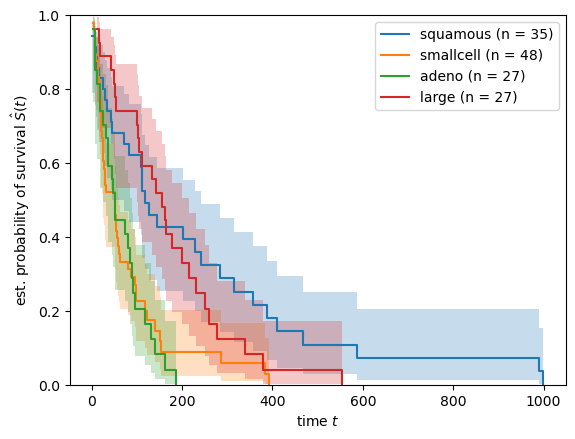

In [9]:
for value in data_x["Celltype"].unique():
    mask = data_x["Celltype"] == value
    time_cell, survival_prob_cell, conf_int = kaplan_meier_estimator(
        data_y["Status"][mask], data_y["Survival_in_days"][mask], conf_type="log-log"
    )
    plt.step(time_cell, survival_prob_cell, where="post",
             label=f"{value} (n = {mask.sum()})")
    plt.fill_between(time_cell, conf_int[0],
                     conf_int[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

There seems to be a significant difference between survival of patients with squamous/large cells as compared to small/adeno cells, which we can again quantify using a log-rank test:

In [10]:
chi_squared, p_value, statistics, covariance_matrix = compare_survival(
    data_y,
    list(map(lambda x: x == "squamous" or x == "large", data_x["Celltype"])),
    True,
)
print(f"chi-squared:\n{chi_squared}")
print(f"\np-value:\n{p_value}")
print(f"\nstatistics:\n{statistics}")
print(f"\ncovariance matrix:\n{covariance_matrix}")

chi-squared:
24.524185922668472

p-value:
7.338289632999644e-07

statistics:
       counts  observed   expected  statistic
group                                        
False      75        71  45.795844  25.204156
True       62        57  82.204156 -25.204156

covariance matrix:
[[ 25.9029794 -25.9029794]
 [-25.9029794  25.9029794]]


Indeed, in this case, there is a statistically significant (>95% CI) difference between the survival of these two groups.

### Multivariate models

Now, let's consider the simplest non-parametric multivariate model: Cox's proportional hazards model. First, the categorical variables in the dataset need to be one-hot encoded:

In [11]:
from sksurv.preprocessing import OneHotEncoder

data_x_numeric = OneHotEncoder().fit_transform(data_x)
data_x_numeric.head()

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
0,69.0,0.0,0.0,1.0,60.0,7.0,0.0,0.0
1,64.0,0.0,0.0,1.0,70.0,5.0,1.0,0.0
2,38.0,0.0,0.0,1.0,60.0,3.0,0.0,0.0
3,63.0,0.0,0.0,1.0,60.0,9.0,1.0,0.0
4,65.0,0.0,0.0,1.0,70.0,11.0,1.0,0.0


The API for fitting a survival model in scikit-survival mirrors that of scikit-learn:

In [12]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_numeric, data_y)

CoxPHSurvivalAnalysis()

After fitting the Cox model, we obtain a set of log hazard ratios for each covariate:

In [13]:
pd.Series(estimator.coef_, index=data_x_numeric.columns)

Age_in_years            -0.008549
Celltype=large          -0.788672
Celltype=smallcell      -0.331813
Celltype=squamous       -1.188299
Karnofsky_score         -0.032622
Months_from_Diagnosis   -0.000092
Prior_therapy=yes        0.072327
Treatment=test           0.289936
dtype: float64

We can then predict patient-specific survival functions, as shown here for synthetic data:

In [14]:
x_new = pd.DataFrame.from_dict(
    {
        1: [65, 0, 0, 1, 60, 1, 0, 1],
        2: [65, 0, 0, 1, 60, 1, 0, 0],
        3: [65, 0, 1, 0, 60, 1, 0, 0],
        4: [65, 0, 1, 0, 60, 1, 0, 1],
    },
    columns=data_x_numeric.columns,
    orient="index",
)
x_new

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
1,65,0,0,1,60,1,0,1
2,65,0,0,1,60,1,0,0
3,65,0,1,0,60,1,0,0
4,65,0,1,0,60,1,0,1


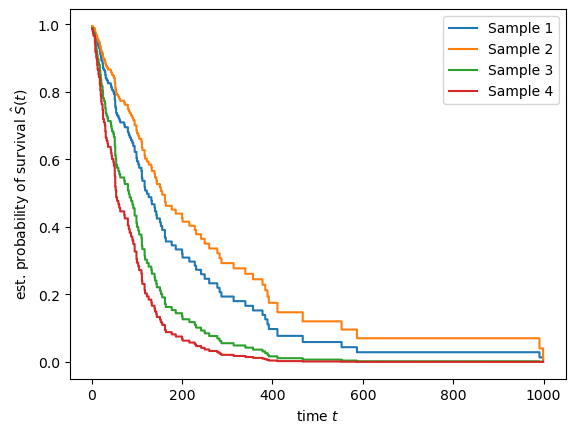

In [15]:
import numpy as np

pred_surv = estimator.predict_survival_function(x_new)
time_points = np.arange(1, 1000)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points),
             where="post", label=f"Sample {i + 1}")
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

### [Evaluation of survival models](https://scikit-survival.readthedocs.io/en/stable/user_guide/evaluating-survival-models.html)

There are a few standard means by which we can assess the performance of our survival models. Because censoring is present in both the train and test data, typical metrics like RMS error or correlation matrices aren't applicable to survival analysis. The simplest gold standard is a generalization of the ROC curve called Harrell's concordance index, or c-index. One can interpret this score in an identical way to the typical area under the ROC curve metric of binary classification.

Let's assess the performance of the Cox model we fit in the previous section:

In [16]:
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(data_x_numeric)
result = concordance_index_censored(
    data_y["Status"], data_y["Survival_in_days"], prediction)
result[0]

0.7362562471603816

Equivalently, we can simply call the score method of the estimator:

In [17]:
estimator.score(data_x_numeric, data_y)

0.7362562471603816

Another gold standard is the time-dependent Brier score, which is a generalization of mean squared error to right-censored survival data.

$\vdots$

### Feature selection

To assess the most predictively relevant features, we can do the following:

In [18]:
import numpy as np


def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores


scores = fit_and_score_features(data_x_numeric.values, data_y)
pd.Series(scores, index=data_x_numeric.columns).sort_values(ascending=False)

Karnofsky_score          0.709280
Celltype=smallcell       0.572581
Celltype=large           0.561620
Celltype=squamous        0.550545
Treatment=test           0.525386
Age_in_years             0.515107
Months_from_Diagnosis    0.509030
Prior_therapy=yes        0.494434
dtype: float64

Furthermore, we can perform a grid search to exclude irrelevant features from our models.

In [19]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

pipe = Pipeline(
    [
        ("encode", OneHotEncoder()),
        ("select", SelectKBest(fit_and_score_features, k=3)),
        ("model", CoxPHSurvivalAnalysis()),
    ]
)

In [20]:
from sklearn.model_selection import GridSearchCV, KFold

param_grid = {"select__k": np.arange(1, data_x_numeric.shape[1] + 1)}
cv = KFold(n_splits=3, random_state=1, shuffle=True)
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)
gcv.fit(data_x, data_y)

results = pd.DataFrame(gcv.cv_results_).sort_values(
    by="mean_test_score", ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]

,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
4,5,{'select__k': 5},0.716093,0.719862,0.716685,0.717547,0.001655,1,0.732087,0.742432,0.731710,0.735410,0.004968
3,4,{'select__k': 4},0.697368,0.722332,0.727324,0.715675,0.013104,2,0.732477,0.743090,0.727138,0.734235,0.006630
7,8,{'select__k': 8},0.706478,0.723320,0.716685,0.715494,0.006927,3,0.739356,0.746249,0.737519,0.741041,0.003758
5,6,{'select__k': 6},0.704453,0.719368,0.716685,0.713502,0.006491,4,0.735722,0.747565,0.731710,0.738332,0.006731
6,7,{'select__k': 7},0.700405,0.719368,0.720045,0.713272,0.009103,5,0.741173,0.742564,0.728621,0.737453,0.006271
1,2,{'select__k': 2},0.699393,0.717885,0.718365,0.711881,0.008833,6,0.732087,0.727428,0.714409,0.724642,0.007481
0,1,{'select__k': 1},0.698887,0.707510,0.712206,0.706201,0.005516,7,0.710670,0.714793,0.700445,0.708636,0.006032
2,3,{'select__k': 3},0.708502,0.714427,0.694849,0.705926,0.008198,8,0.734034,0.722559,0.716634,0.724409,0.007223


From the grid search, we see that it would suffice to select only the top 5 most predictive features for this model (`Celltype=large`, `Celltype=smallcell`, `Celltype=squamous`, `Karnofsky_score`, and `Treatment=test`). Fitting the corresponding reduced model yields the following log hazard ratios:

In [23]:
pipe.set_params(**gcv.best_params_)
pipe.fit(data_x, data_y)

encoder, transformer, final_estimator = [s[1] for s in pipe.steps]
pd.Series(final_estimator.coef_, index=encoder.encoded_columns_[
          transformer.get_support()])

Celltype=large       -0.754714
Celltype=smallcell   -0.328059
Celltype=squamous    -1.147673
Karnofsky_score      -0.031112
Treatment=test        0.257313
dtype: float64

# [Hyperparameter tuning](https://scikit-survival.readthedocs.io/en/stable/user_guide/evaluating-survival-models.html#Using-Metrics-in-Hyper-parameter-Search)

$\vdots$